In [1]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


In [2]:
size = tlp.ProgressParallel(n_jobs=network_count, total=network_count)(
  joblib.delayed(get_size)(network_index) for network_index in network_indices
)
  
size = pd.DataFrame(size)

  0%|          | 0/26 [00:00<?, ?it/s]

In [3]:
stats = get_all_stats(network_indices=network_indices)
 
stats = stats[['density', 'degree assortativity', 'average clustering coefficient']]

  0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
diameter = get_diameter()

  0%|          | 0/26 [00:00<?, ?it/s]

In [7]:
def logistic_regression_I(network_index: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(
      f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

auc_I = {
  network_index: logistic_regression_I(network_index) 
  for network_index in network_indices}

In [9]:
def logistic_regression_I_II(network_index: int, hypergraph: bool):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(
        f'data/{network_index:02}/features/time_agnostic/{heuristic}.npy'))
    
  if hypergraph:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
        for aggregation_strategy in aggregation_strategies:
          X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'
            ))
  else:
    for time_strategy in time_strategies:
      for nodepair_strategy in nodepair_strategies:
          X[(time_strategy, nodepair_strategy)] = (
            np.load(
              f'data/{network_index:02}/features/time_node/'
              f'{time_strategy}_{nodepair_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_I_II = {
  network_index: (
    logistic_regression_I_II(
      network_index, hypergraph=network_index in hypergraphs
    )
  )
  for network_index in network_indices
}

In [11]:
def logistic_regression_III(network_index: int, hypergraph: bool):
  X = dict()
  
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      if hypergraph:
        for aggregation_strategy in aggregation_strategies:
          if aggregation_strategy not in ['m2', 'm3']:
            X[(heuristic, time_strategy, aggregation_strategy)] = np.load(
                f'data/{network_index:02}/features/time_edge/'
                f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy')
      else:
        X[(heuristic, time_strategy)] = np.load(
          f'data/{network_index:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy')
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network_index:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

auc_III = {
  network_index: logistic_regression_III(
    network_index, hypergraph=network_index in hypergraphs)
  for network_index in network_indices}

In [19]:
df = pd.concat([
  size,
  stats,
  diameter,
  pd.Series(auc_I, name='I'),
  pd.Series(auc_I_II, name='I+II'),
  pd.Series(auc_III, name='III')
], axis=1)

In [21]:
df.columns

Index(['nodes', 'edges', 'events', 'density', 'degree assortativity',
       'average clustering coefficient', 'diameter', 'I', 'I+II', 'III'],
      dtype='object')

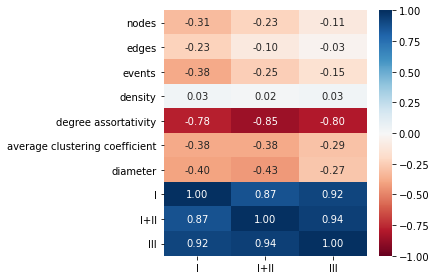

In [28]:
sns.heatmap(
  df.corr().loc[['I', 'I+II', 'III']].T, 
  vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='RdBu')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.savefig('figures/heatmap.pdf')